Import neccessary packages

In [33]:
from sklearn import linear_model
import numpy as np
import os

import xarray as xr
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

Set variables

In [34]:
StepSize = 1 # how many output steps (months!) to predict over

halo_size = 1
halo_list = (range(-halo_size, halo_size+1))
#Calculate x,y position in each feature list to use as 'now' value
xy=2*(halo_size^2+halo_size) # if using a 2-d halo in x and y....if using a 3-d halo need to recalculate!

# region at start of run to learn from
split_index = 1200   # learn from first 100 years

#my_var = 'Ttave'
#my_var = 'Stave'
my_var = 'uVeltave'
#my_var = 'uVeltave'


Read in the data

In [35]:
DIR = '/data/hpcdata/users/racfur/MITGCM_OUTPUT/'
exp_list = ['20000yr_Windx1.00_mm_diag/']
file_list =[]
for exp in exp_list:
    for filename in os.listdir(os.path.join(DIR,exp)):
        if filename.__contains__('cat_tave'):
            file_list.append(os.path.join(DIR,exp,filename))

print(file_list)

ds   = xr.open_dataset(file_list[0])

ds_var=ds[my_var]

['/data/hpcdata/users/racfur/MITGCM_OUTPUT/20000yr_Windx1.00_mm_diag/part_cat_tave.nc']


Plot time series of input (and output) data for a random point

In [ ]:
# Plot a timeseries of variable value at set grid point and its halo, 
# to use this to predict the value of that variable at a later time step

z=np.random.randint(1,41) # 42 points in z-dir - skip edge points, don't want to be near surface or bottom boundary *for now*.
x=np.random.randint(1,9)  # 11 points in x dir - skip edge points to allow non-boundary halo. Skip last 2 points, as last point is land
y=np.random.randint(1,76)  # 78 points in y dir - skip edge points to allow non-boundary halo. Skip last 2 points, as last point is land

fig1 = plt.figure(figsize=(15,4))

colours=['blue' , 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange', 'purple', 'aquarmarine',
         'gold', 'brown', 'pink', 'grey', 'olive', 'yellowgreen', 'violet', 'teal', 'sienna',
         'salmon', 'plum', 'navy', 'orangered', 'tan', 'lightblue', 'khaki', 'indigo', 
         'darkgreen', 'crimson']
colours.insert(xy, 'black')
styles=['dotted'] * 28
styles.insert(xy, 'solid')
alphas=[0.4] * 28
alphas.insert(xy, 1.)

i=0
for x_offset in halo_list:
    for y_offset in halo_list:
        ds_var[:split_index,z,y+y_offset,x+x_offset].plot(label=('x+%d,y+%d' % (x_offset, y_offset)), 
                                                          alpha=0.4, xscale='log', color=colours[i], ls=styles[i])
        ds_var[split_index:,z,y+y_offset,x+x_offset].plot(alpha=1, xscale='log', color=colours[i], ls=styles[i])
        i=i+1

fig1.legend()
fig1.savefig('../regression_plots/'+my_var+'_'+str(x)+'.'+str(y)+'.'+str(z)+'.png')

Read in data as training and test data

In [20]:
inputs_tr = []
nxt_outputs_tr = []

inputs_te = []
nxt_outputs_te = []

# Read in as training and test data (rather than reading in all data and splitting),
# so we can learn on first n time steps, and test on rest

for z in range(1,40,10):
    for x in range(1,9,3):
        for y in range(1,76,10):
            for time in range(0, split_index, 40):
                inputs_tr.append([ds_var.isel(T=time)[z,y+y_offset,x+x_offset] for x_offset in halo_list for y_offset in halo_list])
                nxt_outputs_tr.append([ds_var.isel(T=time+StepSize)[z,y,x]])
            for time in range(split_index, len(ds.T.data)-StepSize, 400):
                inputs_te.append([ds_var.isel(T=time)[z,y+y_offset,x+x_offset] for x_offset in halo_list for y_offset in halo_list])
                nxt_outputs_te.append([ds_var.isel(T=time+StepSize)[z,y,x]])
                
inputs_tr=np.asarray(inputs_tr)
nxt_outputs_tr=np.asarray(nxt_outputs_tr)

inputs_te=np.asarray(inputs_te)
nxt_outputs_te=np.asarray(nxt_outputs_te)

#print(inputs_tr.shape, nxt_outputs_tr.shape)
#print(inputs_te.shape, nxt_outputs_te.shape)

(2880, 9) (2880, 1)
(9504, 9) (9504, 1)


Normalise Data

In [21]:
### Normalise (based on training data only)
def normalise_data(train,test):
    train_mean, train_std = np.mean(train), np.std(train)
    norm_train = (train - train_mean) / train_std
    norm_test  = (test - train_mean) / train_std
    return norm_train, norm_test

# Calc mean and std for re-forming predictions
nxt_outputs_tr_mean = np.mean(nxt_outputs_tr)
nxt_outputs_tr_std = np.std(nxt_outputs_tr)

# normalise the data
norm_inputs_tr = np.zeros(inputs_tr.shape)
norm_inputs_te = np.zeros(inputs_te.shape)

norm_nxt_outputs_tr, norm_nxt_outputs_te = normalise_data(nxt_outputs_tr[:], nxt_outputs_te[:])
for i in range(inputs_tr.shape[1]):  #loop over each feature, normalising individually
    norm_inputs_tr[:, i], norm_inputs_te[:, i] = normalise_data(inputs_tr[:, i], inputs_te[:, i])

Set up a model to directly redict variable value at next time step

[0.9967625347961973, 0.9967625347959667, 0.9967625347941226, 0.9967625347731519, 0.9967625345889112, 0.9967625324977146, 0.9967625142297395, 0.9967623108344347, 0.9967606285043173, 0.9967447985966961, 0.9966554076193246, 0.9962408215412054, 0.9951189144860468, 0.9921763376623632]
[0.9998981976532939, 0.9998981976563822, 0.9998981976617954, 0.9998981976727305, 0.9998981976353706, 0.99989819670674, 0.9998981872781221, 0.9998980776411331, 0.9998971643530887, 0.999888683098076, 0.9998419724742718, 0.9996159607969065, 0.9988642708528829, 0.9965514703679071]


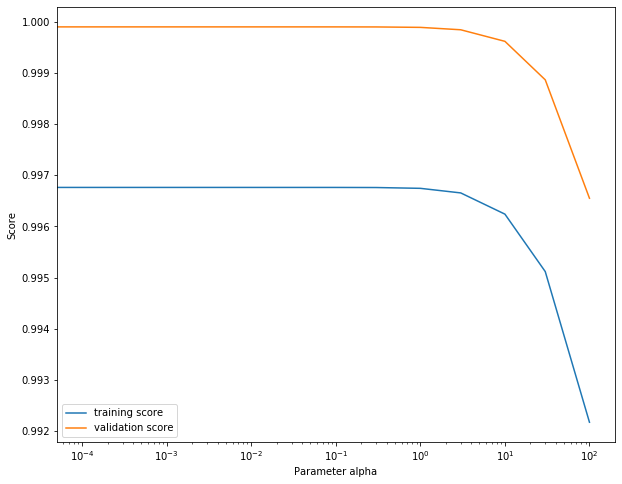

In [22]:
#Tune alpha parameter - model to predict value at next time step

alpha_s = [0.00, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10, 30, 100]
train_scores = list()
val_scores = list()

for alpha in alpha_s:
    model_nxt = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    # Fit model based on training data (and alpha)
    model_nxt.fit(norm_inputs_tr, norm_nxt_outputs_tr)
    train_scores.append(model_nxt.score(norm_inputs_tr, norm_nxt_outputs_tr))
    val_scores.append(model_nxt.score(norm_inputs_te, norm_nxt_outputs_te))

#print(train_scores)
#print(val_scores)

# Do the plotting
plt.figure(figsize=(10,8))
plt.semilogx(alpha_s, train_scores, label='training score')
plt.semilogx(alpha_s, val_scores, label='validation score')
plt.ylabel('Score')
plt.xlabel('Parameter alpha')
plt.legend()
plt.savefig('../regression_plots/'+my_var+'_scoreValpha_nxt.png')
plt.show()

In [23]:
#run model to predict next time step value, having selected a sensible alpha from above

model_nxt= linear_model.Ridge(alpha=1.0, fit_intercept=False)

model_nxt.fit(norm_inputs_tr, norm_nxt_outputs_tr )  # train to evaluate the value at the next time step...

print('coefs     : ' + str(model_nxt.coef_))
print('intercept : ' + str(model_nxt.intercept_))

# how to evaluate test stats...cross validation methods (k-fold, leave one out etc)
# not valid here, as we have a specific training test split we wish to preserve

# Explained variance score: 1 is perfect prediction
# and 0 means that there is no linear relationship
# between X and y.
nxt_score = model_nxt.score(norm_inputs_te, norm_nxt_outputs_te)

print('score     : '+str(nxt_score))

coefs     : [[ 0.01810763  0.03006554 -0.03010952 -0.00441334  0.93879619  0.03824642
  -0.00911468  0.02366209 -0.00551456]]
intercept : 0.0
score     : 0.999888683098076


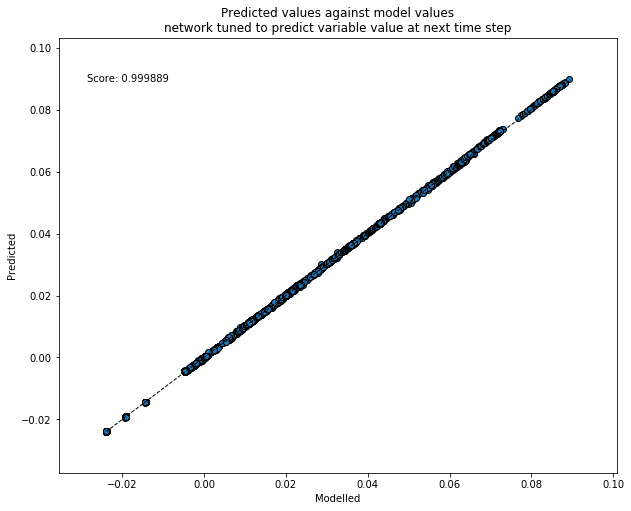

In [24]:
# Predict values across test set and plot against 'truth'
predicted = model_nxt.predict(norm_inputs_te)

#de-normalise
denorm_predicted = predicted*nxt_outputs_tr_std+nxt_outputs_tr_mean

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(nxt_outputs_te, denorm_predicted, edgecolors=(0, 0, 0))
ax.plot([nxt_outputs_te.min(), nxt_outputs_te.max()], [nxt_outputs_te.min(), nxt_outputs_te.max()], 'k--', lw=1)
ax.set_xlabel('Modelled')
ax.set_ylabel('Predicted')
ax.set_title('Predicted values against model values\nnetwork tuned to predict variable value at next time step')
ax.text(.05,.9,'Score: {:.6f}'.format(nxt_score),transform=ax.transAxes)
plt.savefig('../regression_plots/'+my_var+'_predictedVtruth_nxt.png')
plt.show()

Attempts to bug fix code - something is wrong as test data always performs better than training data....?!?!

6192
[-0.59104443]


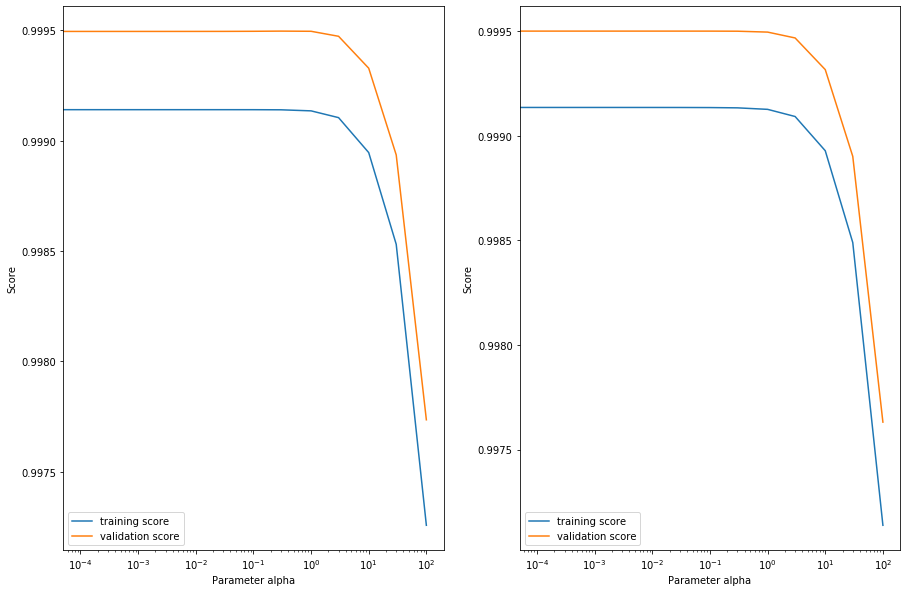

In [25]:
# Results are suspicious... validation score should be worse than test, and should increase with alpha...
# possible its due to the organised separation of test and train... investigate by combining train 
# and test data and then randomly separating and running...

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

inputs = np.vstack((norm_inputs_tr, norm_inputs_te))
outputs = np.vstack((norm_nxt_outputs_tr, norm_nxt_outputs_te))

data = np.hstack((inputs, outputs))
np.random.shuffle(data)
in_train, in_test, out_train, out_test = train_test_split(data[:,0:8], data[:,9:] , test_size=0.5, random_state=0)

alpha_s = [0.00, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10, 30, 100]
train_scores = []
val_scores = []
myr2_scores1 = []
myr2_scores2 = []

print(len(out_test))
print(out_test[0])

for alpha in alpha_s:
    model_test = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    # Fit model based on training data (and alpha)
    model_test.fit(in_train, out_train)
    myr2_scores1.append(r2_score(out_test, model_test.predict(in_test)))
    myr2_scores2.append(r2_score(out_train, model_test.predict(in_train)))
    train_scores.append(model_test.score(in_train, out_train))
    val_scores.append(model_test.score(in_test, out_test))

# Do the plotting
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.semilogx(alpha_s, train_scores, label='training score')
plt.semilogx(alpha_s, val_scores, label='validation score')
#plt.semilogx(alpha_s, myr2_scores1, label='r2 score1', ls='dotted')
#plt.semilogx(alpha_s, myr2_scores2, label='r2 score2', ls='dotted')
plt.ylabel('Score')
plt.xlabel('Parameter alpha')
plt.legend()

#Redo this with TEST DATA USED FOR TRAINING - BUT KEEP ALL OTHER THINGS THE SAME, LABELLING ETC.
# and plot side by side - we should see scores change
train_scores = []
val_scores = []
for alpha in alpha_s:
    model_test2 = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    # Fit model based on *test* data (and alpha)
    model_test2.fit(in_test, out_test)
    train_scores.append(model_test2.score(in_train, out_train))
    val_scores.append(model_test2.score(in_test, out_test))

# Do the plotting
plt.subplot(122)
plt.semilogx(alpha_s, train_scores, label='training score')
plt.semilogx(alpha_s, val_scores, label='validation score')
plt.ylabel('Score')
plt.xlabel('Parameter alpha')
plt.legend()

plt.show()

#  seems to give a very similar pattern... the score drops of with increased regularisation, on both training and test data...and test data scores better than train data ALL the time!!!?!?!
## What is going on?!

Define a new model to predict tendancy (difference between now and next step)

In [26]:
# A model to predict the tendancy in that variable (difference between now and next points)...

#redefine new outputs as the difference between 'next' and 'now'
tnd_outputs_tr = nxt_outputs_tr[:,0] - inputs_tr[:,xy]
tnd_outputs_te = nxt_outputs_te[:,0] - inputs_te[:,xy]
#print(tnd_outputs_tr.shape, tnd_outputs_te.shape)

#normalise these new outputs
norm_tnd_outputs_tr, norm_tnd_outputs_te = normalise_data(tnd_outputs_tr[:], tnd_outputs_te[:])

# store these values to de-normalise
tnd_outputs_tr_mean = np.mean(tnd_outputs_tr)
tnd_outputs_tr_std  = np.std(tnd_outputs_tr)

(2880,) (9504,)


[0.024388333033059095, 0.02438833303300192, 0.024388333032545062, 0.02438833302734711, 0.024388332981664543, 0.024388332462520812, 0.024388327911341826, 0.02438827663048382, 0.024387838026667108, 0.02438327899443504, 0.024351672779110434, 0.024154445267797975, 0.02350655425689252, 0.021760104161718807]
[-8.042074004877064, -8.042071273739994, -8.042065811478071, -8.042046693689576, -8.041992072535717, -8.041800911309688, -8.041254845978964, -8.039344887615615, -8.033898554102416, -8.014955258642823, -7.961792438434394, -7.787982601550116, -7.403764147814763, -6.74888891344792]


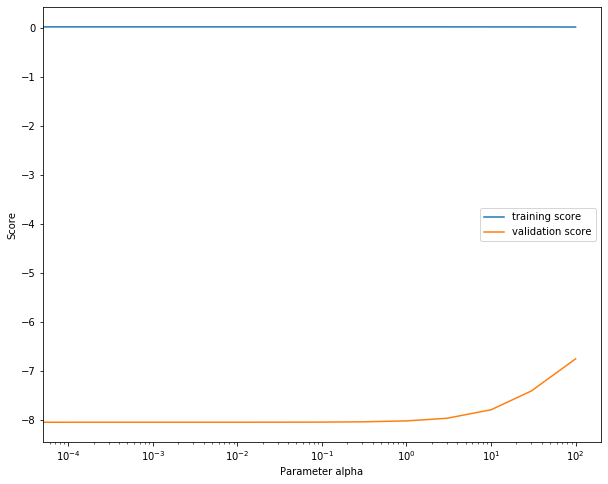

In [27]:
#Tune alpha parameter - tendancy model

alpha_s = [0.00, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10, 30, 100]
train_scores = list()
val_scores = list()

for alpha in alpha_s:
    model_tnd = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    # Fit model based on training data (and alpha)
    model_tnd.fit(norm_inputs_tr, norm_tnd_outputs_tr )
    train_scores.append(model_tnd.score(norm_inputs_tr, norm_tnd_outputs_tr))
    val_scores.append(model_tnd.score(norm_inputs_te, norm_tnd_outputs_te))

#print(train_scores)
#print(val_scores)

# Do the plotting
plt.figure(figsize=(10,8))
plt.semilogx(alpha_s, train_scores, label='training score')
plt.semilogx(alpha_s, val_scores, label='validation score')
plt.ylabel('Score')
plt.xlabel('Parameter alpha')
plt.legend()
plt.savefig('../regression_plots/'+my_var+'_scoreValpha_tnd.png')
plt.show()

In [28]:
#run model to predict tendancy, based on carefully chosen alpha from above

model_tnd= linear_model.Ridge(alpha=1.0, fit_intercept=False)

model_tnd.fit(norm_inputs_tr, norm_tnd_outputs_tr )  # train to evaluate the value at the next time step...

print('coefs     : ' + str(model_tnd.coef_))
print('intercept : ' + str(model_tnd.intercept_))

# how to evaluate test stats...cross validation methods (k-fold, leave one out etc)
# not valid here, as we have a specific training test split we wish to preserve
tnd_score = model_tnd.score(norm_inputs_te, norm_tnd_outputs_te)
print('score     : '+str(tnd_score))

coefs     : [ 0.30444233  0.17672767 -0.20603217 -0.42332936  0.07423628  0.04284717
  0.16992415 -0.08804878  0.0660733 ]
intercept : 0.0
score     : -8.014955258642823


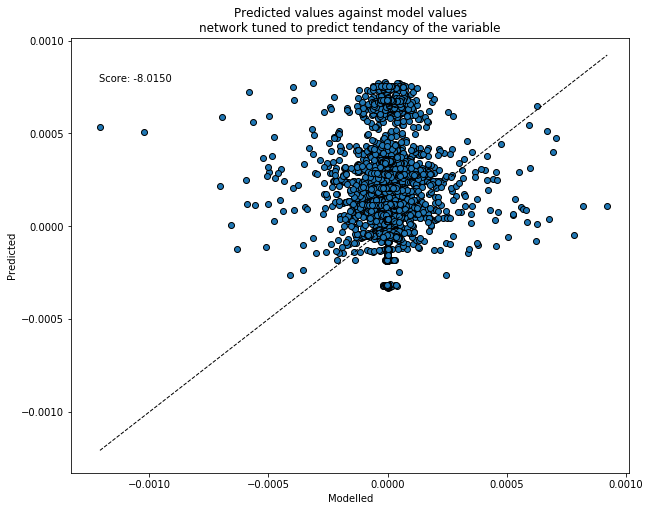

In [32]:
# Predict values across test set and plot against 'truth'

predicted = model_tnd.predict(norm_inputs_te)  #cross_val_predict(model_next, norm_inputs_te, norm_outputs_te, cv=1)

#de-normalise
denorm_predicted = predicted*tnd_outputs_tr_std+tnd_outputs_tr_mean

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(tnd_outputs_te, denorm_predicted, edgecolors=(0, 0, 0))
ax.plot([tnd_outputs_te.min(), tnd_outputs_te.max()], [tnd_outputs_te.min(), tnd_outputs_te.max()], 'k--', lw=1)
ax.set_xlabel('Modelled')
ax.set_ylabel('Predicted')
ax.set_ylim(tnd_outputs_te.min()*1.1, tnd_outputs_te.max()*1.1)
ax.set_xlim(tnd_outputs_te.min()*1.1, tnd_outputs_te.max()*1.1)
ax.set_title('Predicted values against model values\nnetwork tuned to predict tendancy of the variable')
ax.text(0.05,0.9,'Score: {:.4f}'.format(tnd_score), transform=ax.transAxes)
plt.savefig('../regression_plots/'+my_var+'_predictedVtruth_tnd.png')
plt.show()